In [1]:
import matplotlib.pyplot as plt
import scipy.io
from scipy.ndimage import gaussian_filter
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image, ImageOps
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.optimizers import Adam
import scipy.io
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, models, optimizers
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, BatchNormalization, Activation, Conv2DTranspose

In [2]:
def generate_density_map(x, y, map_size=(224, 224), sigma=4):
    """
    Tworzy mapę gęstości dla podanych współrzędnych punktów (x, y).

    Args:
        x (np.ndarray): Współrzędne x punktów.
        y (np.ndarray): Współrzędne y punktów.
        map_size (tuple): Rozmiar mapy gęstości (szerokość, wysokość).
        sigma (float): Odchylenie standardowe dla filtru Gaussa.

    Returns:
        np.ndarray: 2D mapa gęstości o rozmiarze `map_size`.
    """
    density = np.zeros(map_size, dtype=np.float32)
    h, w = map_size[1], map_size[0]  # uwaga: wysokość to y, szerokość to x

    for i in range(len(x)):
        xi = min(w - 1, max(0, int(x[i])))
        yi = min(h - 1, max(0, int(y[i])))
        density[yi, xi] += 1

    # Zastosowanie filtru Gaussa do wygładzenia (czyli rozkładania punktów)
    density = gaussian_filter(density, sigma=sigma, mode='reflect')

    return density


In [3]:
def load_dataset(image_dir, gt_dir, target_size=(224, 224)):
    X = []
    y = []
    c = 0
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    image_files.sort()  # opcjonalnie

    if not image_files:
        raise ValueError("Brak plików .jpg w podanym katalogu!")

    for img_file in image_files:
        img_path = os.path.join(image_dir, img_file)
        mat_path = os.path.join(gt_dir, 'GT_' + img_file.replace('.jpg', '.mat'))

        # Wczytaj i przeskaluj obraz do dokładnego rozmiaru target_size (bez paddingu)
        img = Image.open(img_path).convert('RGB')
        img_resized = img.resize(target_size, Image.LANCZOS)

        # Konwersja do numpy + preprocess_input (dla MobileNet)
        img_array = np.array(img_resized, dtype=np.float32)
        img_array = preprocess_input(img_array)

        # Wczytaj ground truth (liczba osób)
        mat = scipy.io.loadmat(mat_path)
        pts = mat['image_info'][0][0][0][0][0]
        x_coords = pts[:,0]
        y_coords = pts[:,1]
        # Skalowanie punktów trzeba zrobić
        scale_x = target_size[0]/img.size[0]
        scale_y = target_size[1]/img.size[1]
        x_coords = scale_x * x_coords
        y_coords = scale_y * y_coords
        # Funkcję do generowania mapy gęstości trzeba zrobić
        dm = generate_density_map(x_coords, y_coords, map_size=target_size)
        X.append(img_array)
        y.append(dm)

    return np.array(X), np.array(y)


In [4]:
X_train, y_train = load_dataset('ShanghaiTech/part_B/train_data/images/', 'ShanghaiTech/part_B/train_data/ground-truth/')

In [5]:
X_test, y_test = load_dataset('ShanghaiTech/part_B/test_data/images/', 'ShanghaiTech/part_B/test_data/ground-truth/')

In [35]:
def build_mobilenet_density_model(input_shape=(224, 224, 3)):
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze MobileNet layers
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output  # np. (7, 7, 1024)

    # Prosty dekoder (możesz go rozbudować)
    x = UpSampling2D(size=(2, 2))(x)      # 14x14
    x = Conv2D(256, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = UpSampling2D(size=(2, 2))(x)      # 28x28
    x = Conv2D(128, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = UpSampling2D(size=(2, 2))(x)      # 56x56
    x = Conv2D(64, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = UpSampling2D(size=(2, 2))(x)      # 112x112
    x = Conv2D(32, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = UpSampling2D(size=(2, 2))(x)      # 224x224
    x = Conv2D(1, 1, padding='same', activation='relu')(x)  # końcowa mapa gęstości

    model = Model(inputs=base_model.input, outputs=x)
    return model

    # Bloki do skip connections (nazwy warstw MobileNet)
    skip_names = [
        'conv_pw_1_relu',   # (112, 112, 64)
        'conv_pw_3_relu',   # (56, 56, 128)
        'conv_pw_5_relu',   # (28, 28, 256)
        'conv_pw_11_relu',  # (14, 14, 512)
    ]
    
    # Pobieramy skip connection warstwy
    skips = [base_model.get_layer(name).output for name in skip_names]

    # Encoder output
    encoder_output = base_model.output  # (7, 7, 1024)

    # Dekoder
    x = encoder_output
    for skip in reversed(skips):
        x = Conv2DTranspose(filters=skip.shape[-1], kernel_size=3, strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Concatenate()([x, skip])
        x = Conv2D(filters=skip.shape[-1], kernel_size=3, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    # Ostatni etap – przywrócenie do (224, 224)
    x = Conv2DTranspose(32, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Warstwa końcowa: 1 kanał z mapą gęstości
    x = Conv2D(1, kernel_size=1, activation='relu', padding='same')(x)

    # Złożenie modelu
    model = Model(inputs=base_model.input, outputs=x)
    
    # Zamrożenie wag encoder'a
    for layer in base_model.layers:
        layer.trainable = False

    return model

In [27]:
model = build_mobilenet_density_model()
model.compile(optimizer=Adam(1e-4), loss='mse', metrics=['mae'])
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 5,977,665 (22.80 MB)

 Trainable params: 2,747,841 (10.48 MB)

 Non-trainable params: 3,229,824 (12.32 MB)

In [28]:
# Function to augment
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

def augment(x, y):
    return data_augmentation(x), y

training_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
training_set = training_set.map(augment)  # augment
training_set = training_set.batch(8).prefetch(tf.data.AUTOTUNE)
history = model.fit(training_set, batch_size=8,
    epochs=10, shuffle=True, validation_data=(X_test, y_test)
)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 51s 805ms/step - loss: 0.0614 - mae: 0.0919 - val_loss: 0.0013 - val_mae: 0.0060
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 732ms/step - loss: 8.3029e-04 - mae: 0.0067 - val_loss: 8.0241e-04 - val_mae: 0.0058
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 739ms/step - loss: 3.4862e-04 - mae: 0.0042 - val_loss: 4.4525e-04 - val_mae: 0.0045
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 743ms/step - loss: 2.4781e-04 - mae: 0.0036 - val_loss: 2.7831e-04 - val_mae: 0.0037
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 733ms/step - loss: 1.8758e-04 - mae: 0.0032 - val_loss: 1.9301e-04 - val_mae: 0.0032
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 731ms/step - loss: 1.5470e-04 - mae: 0.0031 - val_loss: 1.6360e-04 - val_mae: 0.0030
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 743ms/step - loss: 1.3949e-04 - mae: 0.0029 - val_loss: 1.4292e-04 - val_mae: 0.0029
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 743ms/step - loss: 1.2913e-04 - mae: 0.0028 - val_loss: 1.2973e-04 - val_mae:

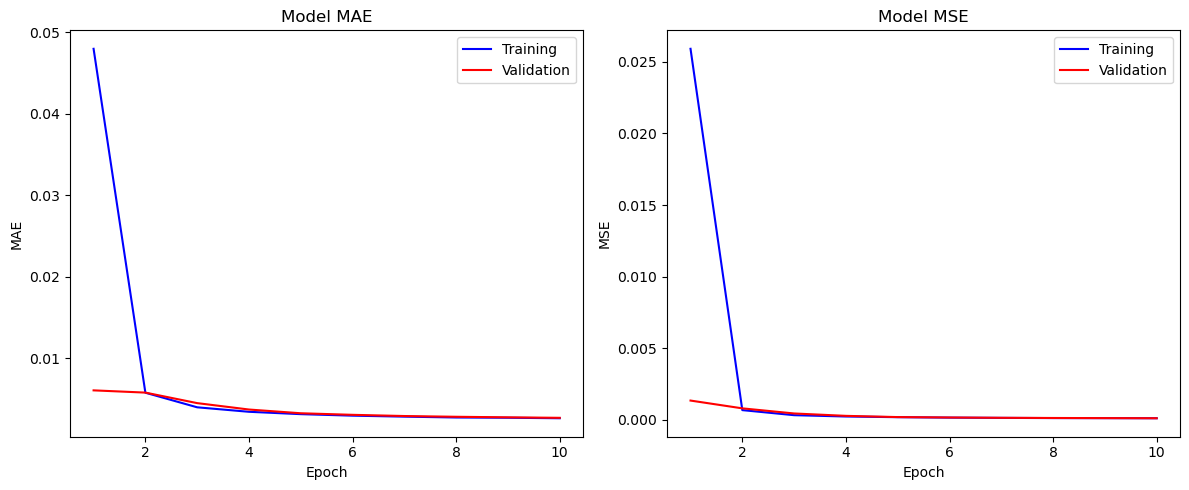

In [29]:
history_dict = history.history

# Getting the metrics
mae = history_dict['mae']
val_mae = history_dict.get('val_mae')
loss = history_dict['loss']
val_loss = history_dict.get('val_loss')

epochs = range(1, len(loss) + 1)

# MAE
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, mae, 'b-', label='Training')
if val_mae:
    plt.plot(epochs, val_mae, 'r-', label='Validation')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Loss (MSE)
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label='Training')
if val_loss:
    plt.plot(epochs, val_loss, 'r-', label='Validation')
plt.title('Model MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


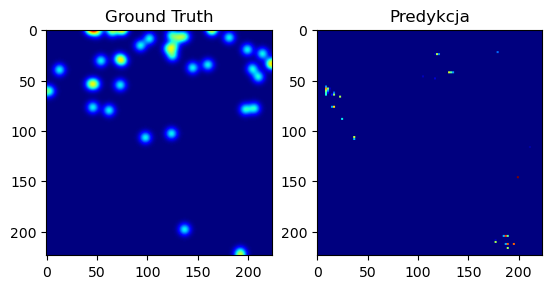

In [33]:
i = 3  # np. pierwszy obraz testowy
pred = model.predict(X_test[i:i+1])[0, :, :, 0]  # (224, 224)

plt.subplot(1, 2, 1)
plt.imshow(y_test[i, :, :], cmap='jet')
plt.title('Ground Truth')

plt.subplot(1, 2, 2)
plt.imshow(pred, cmap='jet')
plt.title('Predykcja')

plt.show()


In [34]:
pred_count = pred.sum()
true_count = y_test[i, :, :].sum()

print(f"Estymowana liczba osób: {pred_count:.2f}, Rzeczywista: {true_count:.2f}")

Estymowana liczba osób: 7.24, Rzeczywista: 37.00


In [32]:
print(np.max(pred), np.min(pred), np.sum(pred))

0.11148578 0.0 2.2188678
